In [ ]:
import geopandas as gpd
import os
import pandas as pd
import folium
import numpy as np
from fastkml import kml
import xml.etree.ElementTree as ET
from shapely.geometry import Polygon
from matplotlib import pyplot as plt
import seaborn as sns



In [ ]:
def parse_kml(kml_file):
    tree = ET.parse(kml_file)
    root = tree.getroot()

    district_data = []
    for placemark in root.findall('.//{http://www.opengis.net/kml/2.2}Placemark'):
        district_name = placemark.findtext('.//{http://www.opengis.net/kml/2.2}name')
        extended_data = placemark.find('.//{http://www.opengis.net/kml/2.2}ExtendedData')
        district_id = extended_data.findtext('.//{http://www.opengis.net/kml/2.2}SimpleData[@name="DISTRICT_L"]')
        state = extended_data.findtext('.//{http://www.opengis.net/kml/2.2}SimpleData[@name="STATE"]')

        coordinates = placemark.find('.//{http://www.opengis.net/kml/2.2}coordinates').text.strip()
        coordinates_list = [tuple(map(float, coord.split(','))) for coord in coordinates.split()]
        polygon = Polygon(coordinates_list)

        district_data.append({
            'district_name': district_name,
            'district_id': district_id,
            'state': state,
            'geometry': polygon
        })

    return pd.DataFrame(district_data)

# Parse KML data
maharashtra_districts = parse_kml('maharashtra.kml')


In [ ]:
def load_dataset(districts=maharashtra_districts, folder_path='patient_data/'):
    files = os.listdir(folder_path)

    csv_files = [file for file in files if file.endswith('.csv')]

    dataset = {}

    # Load each .csv file using a for loop
    for csv_file in csv_files:
        file_path = os.path.join(folder_path, csv_file)
        df = pd.read_csv(file_path)
        df = df[~df['organisationunitname'].str.contains('CIRCLE', case=False)]
        df['organisationunitname'] = df['organisationunitname'].str.replace('DISTRICT', '', case=False).str.strip()
        # df['organisationunitname'] = df['organisationunitname'].str.upper().str.replace('DISTRICT', '').str.replace('CIRCLE', '').str.strip()
        df.loc[df['organisationunitname'] == 'NASIK', 'organisationunitname'] = 'NASHIK'
        df = df.groupby('organisationunitname').sum().reset_index()
        df.rename(columns={'organisationunitname': 'district_name',
                       'newly diagnosed patients-diabetes only': 'diabetes',
                       'newly diagnosed patients-hypertension only': 'hypertension',
                       'newly diagnosed patients-dm & htn (both)': 'diabetes+hypertension',}, inplace=True)
    # Keep only the specified columns and drop others
        df = df[['district_name', 'diabetes', 'hypertension', 'diabetes+hypertension']]
        # print(df)

        df.loc[df['district_name'] == 'AHMADNAGAR', 'district_name'] = 'AHAMADNAGAR'
        df.loc[df['district_name'] == 'AMRAVATI', 'district_name'] = 'AMARAVATI'
        df.loc[df['district_name'] == 'MUMBAI', 'district_name'] = 'MUMBAI CITY'
        df.loc[df['district_name'] == 'OSMANABAD', 'district_name'] = 'USMANABAD'
        df.loc[df['district_name'] == 'RAIGAD', 'district_name'] = 'RAYGAD'
        df.loc[df['district_name'] == 'YEOTMAL', 'district_name'] = 'YAVATMAL'
        df = df[df['district_name'] != 'MAHARASHTRA']
        district_mapping = maharashtra_districts[['district_name', 'district_id']]
        merege_data = pd.merge(df, district_mapping, left_on='district_name', right_on='district_name', how='left')
        dataset[csv_file] = merege_data

    return dataset

In [ ]:
def plot_map(dataset,quarter_no,disease_name):
    quarter_name = ""
    for k in dataset:
        if int(k[0]) == quarter_no:
            quarter_name = k
    disease_data = dataset[quarter_name]
    # Merge disease data with district geometries
    merged_data = pd.merge(maharashtra_districts, disease_data, on='district_id')

    # Convert DataFrame to GeoDataFrame
    gdf = gpd.GeoDataFrame(merged_data, geometry='geometry')

    # Plot the GeoDataFrame
    fig, ax = plt.subplots(figsize=(10, 8))
    gdf.plot(column=disease_name, cmap='viridis', edgecolor='black', legend=True, ax=ax)

    # Annotate district names on the plot
    for idx, row in gdf.iterrows():
        ax.annotate(text=row['district_name_x'], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                    xytext=(3, 3), textcoords="offset points", fontsize=8,color='white',
                    bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))

    # Set plot title and labels
    plt.title(f'No. of Patients of {disease_name} ({quarter_name})')
    plt.xlabel('')
    plt.ylabel('')

    # Show plot
    plt.show()

In [ ]:
def plot_patient_temporal(data_dict, district_name):
    # Initialize figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))
    fig2, ax2 = plt.subplots(figsize=(10, 6))

    # Plot line graphs for each disease
    diseases = ['diabetes', 'hypertension', 'diabetes+hypertension']
    quaters = list(data_dict.keys())
    quaters.sort()
    for disease in diseases:
        patients = [data_dict[quarter][data_dict[quarter]['district_name'] == district_name][disease].iloc[0]
                    if district_name in data_dict[quarter]['district_name'].values else 0
                    for quarter in quaters]

        ax.plot(quaters, patients, label=disease)

        gr = [patients[i+1]-patients[i] for i in range(len(quaters)-1)]
        ax2.plot(quaters[:-1], gr, label=disease)


    dfs = [data_dict[quarter] for quarter in quaters]
    combined_df = pd.concat(dfs, ignore_index=True)

    # Filter out rows where the district name is not 'YourDistrictName'
    filtered_df = combined_df[combined_df['district_name'] == district_name]

    # Select only the columns representing diseases
    disease_data = filtered_df[diseases]

# Calculate correlation matrix
    correlation_matrix = disease_data.corr()

    # Plot correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
    plt.title('Correlation Matrix of Diseases')

    # fig2, ax2 = plt.subplots(figsize=(10, 6))
    # plt.figure(figsize=(10, 8))
    # plt.plot(quaters[:-1],growth_rates)
    # plt.title('Growth Rates per Qauter')
    # plt.ylabel('Growth Rates (%)')
    # plt.xlabel('Quaters')
    # plt.xticks(range(len(data_dict)-1), labels=quaters[:-1])

    # Add title and labels
    ax.set_title(f'Patient Counts for {district_name} by Disease')
    ax.set_xlabel('Quarters')
    ax.set_ylabel('Number of Patients')
    ax.set_xticks(range(len(data_dict)))
    ax.set_xticklabels(quaters, rotation=45)
    ax.legend()
    plt.tight_layout()

    ax2.set_title(f'Patient Growth Rate for {district_name} by Disease')
    ax2.set_xlabel('Quarters')
    ax2.set_ylabel('Growth Rate of Patients')
    ax2.set_xticks(range(len(data_dict)-1))
    ax2.set_xticklabels(quaters[:-1], rotation=45)
    ax2.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
dataset = load_dataset()

In [ ]:
dataset

{'4_Oct_to_Dec_2023.csv':    district_name  diabetes  hypertension  diabetes+hypertension district_id
 0    AHAMADNAGAR    2520.0        2603.0                  260.0         466
 1          AKOLA     222.0         333.0                   59.0         467
 2      AMARAVATI    1001.0        1622.0                  941.0         468
 3     AURANGABAD    1050.0        1608.0                  496.0         469
 4           BEED    3817.0        5708.0                 4205.0         470
 5       BHANDARA    2571.0        8131.0                 1262.0         471
 6       BULDHANA     865.0         559.0                  171.0         472
 7     CHANDRAPUR     266.0         526.0                  119.0         473
 8          DHULE     818.0        1130.0                  453.0         474
 9     GADCHIROLI     668.0         965.0                  435.0         475
 10        GONDIA     508.0         948.0                  390.0         476
 11       HINGOLI     257.0        1088.0          

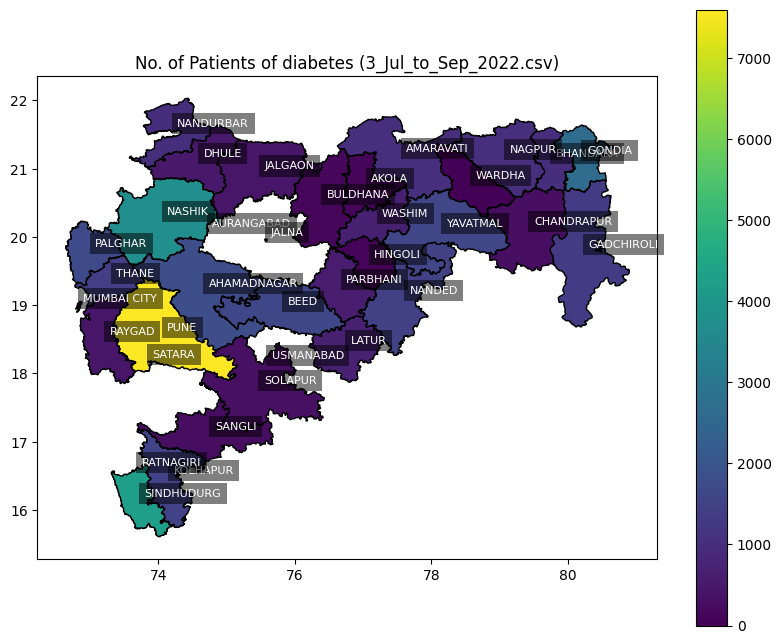

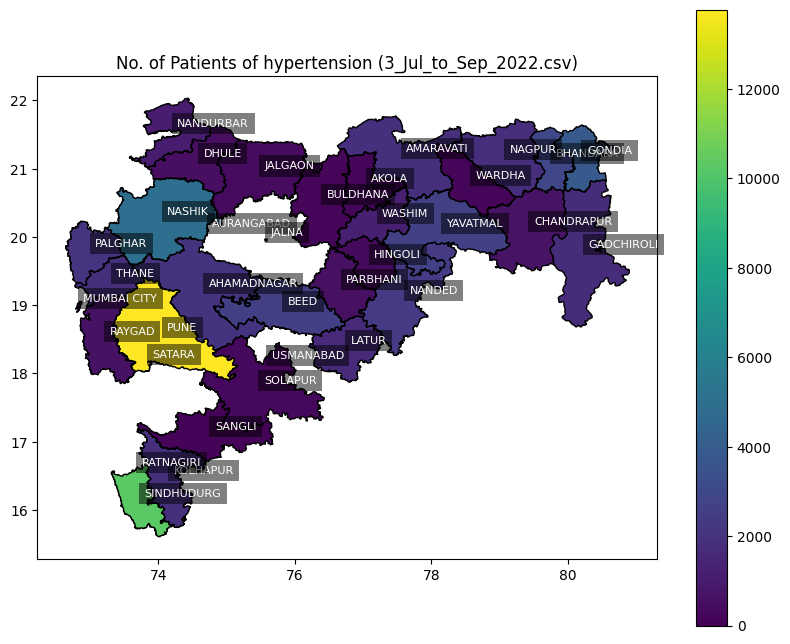

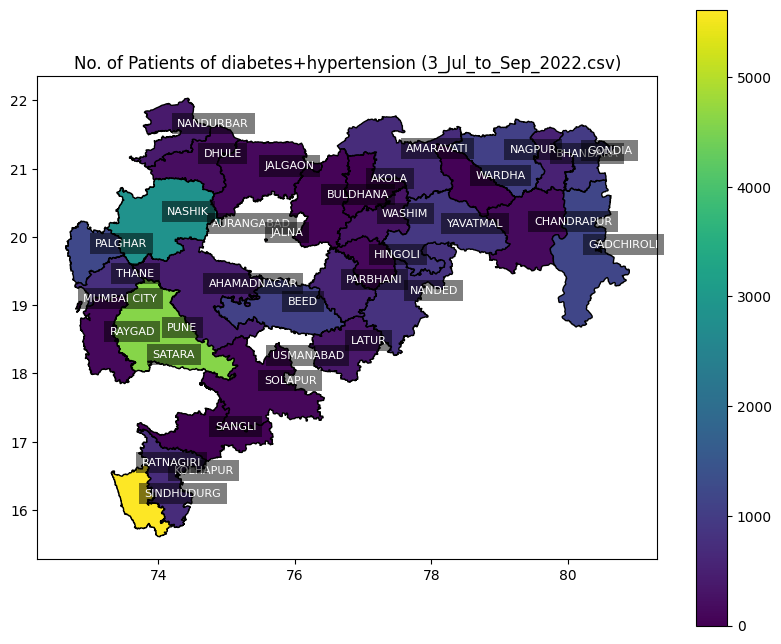

In [ ]:
for disease in ['diabetes', 'hypertension', 'diabetes+hypertension']:
    plot_map(dataset=dataset,quarter_no=3,disease_name=disease)

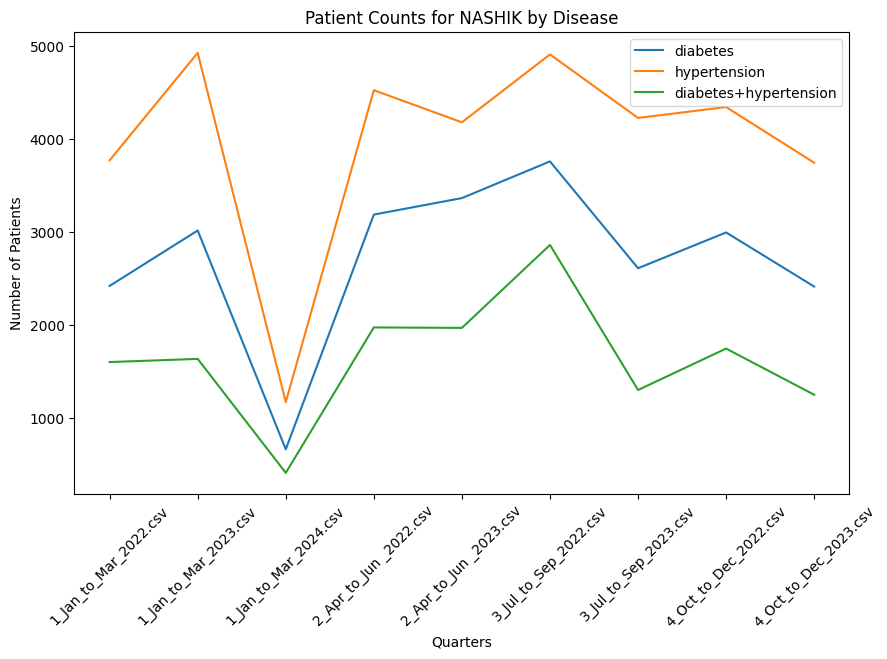

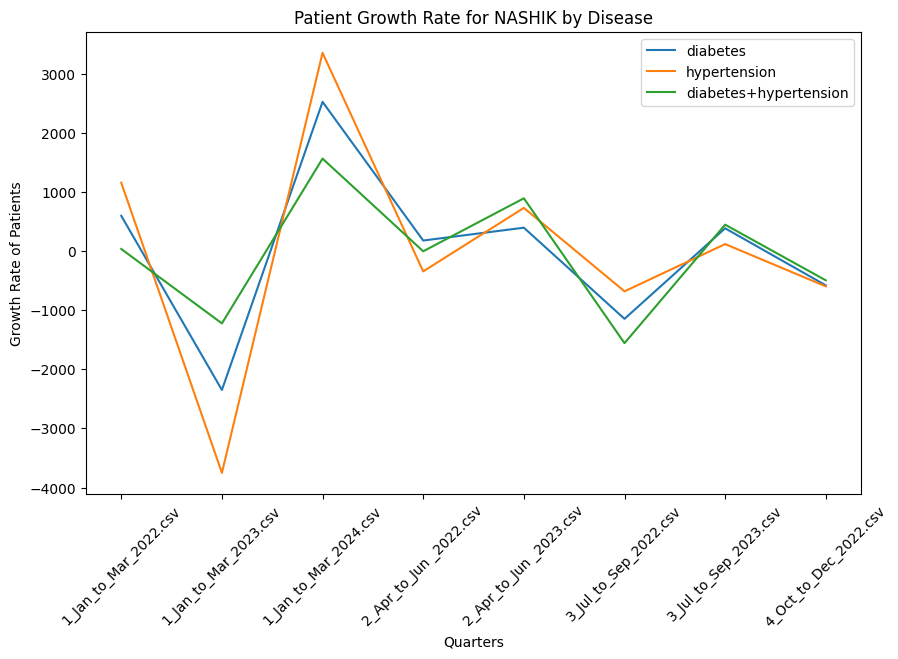

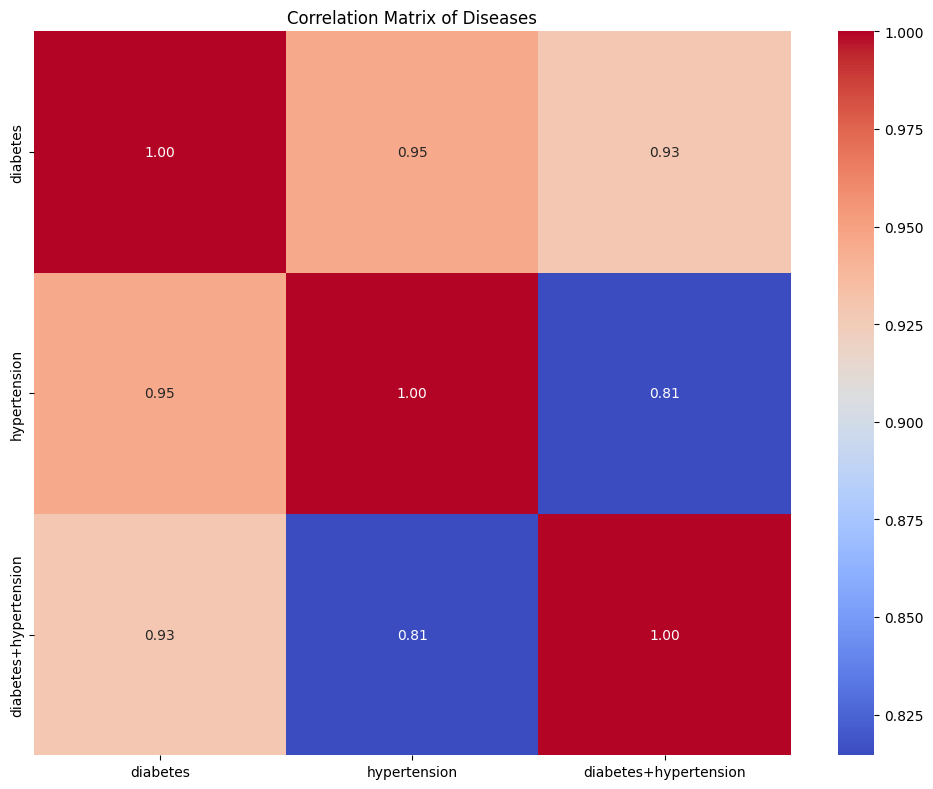

In [ ]:
input_district_name = 'NASHIK'


plot_patient_temporal(dataset, input_district_name)
